In [2]:
import os
import urllib

import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pystac
import pystac_client
import shapely
import stackstac
import torchdata
import xarray as xr
import zen3geo

from torch.utils.data import (  # allows us to load data in batches with multiple workers
    DataLoader,
)

In [3]:
auth = earthaccess.login(persist=True)  # persist EDL login to netrc file

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/work
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 07/09/2023
Using user provided credentials for EDL
Persisting credentials to .netrc


In [4]:
bbox = [-119.1, 36.2, -118.2, 36.9]  # West, South, East, North
time_range = ["2021-08-15T00:00:00Z", "2021-09-15T23:59:59Z"]
collection_ids = ["HLSS30.v2.0"]  # Harmonized Landsat-8 Sentinel-2 (HLS)

In [5]:
query = dict(bbox=bbox, datetime=time_range, collections=collection_ids)

In [6]:
dp = torchdata.datapipes.iter.IterableWrapper(iterable=[query])
dp_pystac_client = dp.search_for_pystac_item(
    catalog_url="https://cmr.earthdata.nasa.gov/stac/LPCLOUD",
)

In [7]:
def get_all_items(item_search) -> pystac.ItemCollection:
    return item_search.items()

In [8]:
dp_hls_items = dp_pystac_client.flatmap(fn=get_all_items)
dp_hls_items

FlatMapperIterDataPipe

In [9]:
it = iter(dp_hls_items)
item = next(it)
print(item)

<Item id=HLS.S30.T11SLA.2021228T182919.v2.0>


In [9]:
def cloud_cover_filter(item: pystac.Item, threshold=20) -> bool:
    """
    Return True if less than or equal to 20% cloud cover, else False.
    """
    return item.properties["eo:cloud_cover"] <= threshold


In [10]:
dp_hls_filtered = dp_hls_items.filter(filter_fn=cloud_cover_filter)

In [11]:
gdal_env = stackstac.DEFAULT_GDAL_ENV.updated(
    always=dict(
        GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
        GDAL_HTTP_MERGE_CONSECUTIVE_RANGES="YES",
        GDAL_HTTP_COOKIEFILE=os.path.expanduser("~/cookies.txt"),
        GDAL_HTTP_COOKIEJAR=os.path.expanduser("~/cookies.txt"),
    )
)
dp_hls_stack = dp_hls_filtered.stack_stac_items(
    assets=["B04", "B03", "B02"],  # RGB bands
    epsg=32611,  # UTM Zone 11N
    resolution=30,  # Spatial resolution of 30 metres
    xy_coords="center",  # pixel centroid coords instead of topleft corner
    dtype=np.float16,  # Use a lightweight data type
    # https://github.com/gjoseph92/stackstac/issues/133
    gdal_env=gdal_env,
)
dp_hls_stack

StackSTACStackerIterDataPipe

In [12]:
it = iter(dp_hls_stack)
dataarray = next(it)
print(dataarray)

<xarray.DataArray 'stackstac-8e3ca8d77b8ee91d3ad357619c9ea9fb' (time: 1,
                                                                band: 3,
                                                                y: 3784, x: 3768)>
dask.array<fetch_raster_window, shape=(1, 3, 3784, 3768), dtype=float16, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2021-08-19T18:54:14.997000
    id              (time) <U34 'HLS.S30.T11SLA.2021231T183919.v2.0'
  * band            (band) <U3 'B04' 'B03' 'B02'
  * x               (x) float64 2.974e+05 2.975e+05 ... 4.104e+05 4.104e+05
  * y               (y) float64 4.102e+06 4.102e+06 ... 3.988e+06 3.988e+06
    eo:cloud_cover  int64 9
    start_datetime  <U24 '2021-08-19T18:54:14.997Z'
    end_datetime    <U24 '2021-08-19T18:54:14.997Z'
    title           (band) <U51 'Download HLS.S30.T11SLA.2021231T183919.v2.0....
    epsg            int64 32611
Attributes:
    spec:        RasterSpec(epsg=3

/home/work/mambaforge/envs/pybayts/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


/home/work/mambaforge/envs/pybayts/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


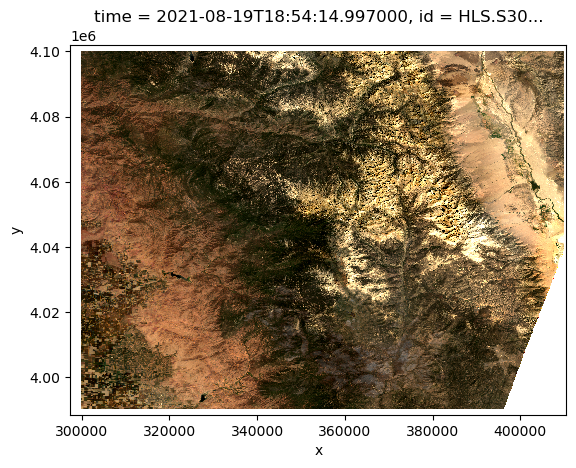

In [13]:
dataarray.isel(time=0).plot.imshow(rgb="band", robust=True)

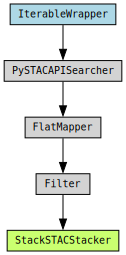

In [17]:
torchdata.datapipes.utils.to_graph(dp=dp_hls_stack)

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rx

from pybayts.bayts import bayts_da_to_date_array
from pybayts.bayts import create_bayts_ts
from pybayts.bayts import deseason_ts
from pybayts.bayts import loop_bayts_update
from pybayts.bayts import merge_cpnf_tseries
from pybayts.data.io import read_and_stack_example_tifs


vv_folder = "../tests/baytsdata/s1vv_tseries/"
ndvi_folder = "../tests/baytsdata/lndvi_tseries/"
pdf_type_l = ("gaussian", "gaussian")
chi = .9
cpnf_min = .5
pdf_forest_l = (0, 0.1)  # mean and sd
pdf_nonforest_l = (-0.5, 0.125)  # mean and sd
bwf_l = (0.1, 0.9)
pdf_type_s = ("gaussian", "gaussian")
pdf_forest_s = (-1, 0.75)  # mean and sd
pdf_nonforest_s = (-4, 1)  # mean and sd
bwf_s = (0.1, 0.9)


ModuleNotFoundError: No module named 'pybayts.bayts'

In [3]:
import pybayts

In [4]:
dir(pybayts)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [ ]:

s1vv_ts = read_and_stack_example_tifs(vv_folder, ds="vv")
s1vv_ts.name = "s1vv"

lndvi_ts = read_and_stack_example_tifs(ndvi_folder, ds="lndvi")
lndvi_ts.name = "lndvi"